# Main

## Librerias a utilizar

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import time
import sys
import hashlib
import ctypes
import subprocess

In [2]:
subprocess.run(['gcc', '-shared', '-o', 'libtarea3.so', '-fPIC', '-O3', 'libtarea3.c'])

CompletedProcess(args=['gcc', '-shared', '-o', 'libtarea3.so', '-fPIC', '-O3', 'libtarea3.c'], returncode=0)

## Importando CSV

In [167]:
df_names = pd.read_table('Popular-Baby-Names-Final.csv',
                         dtype={"Name": "string"})
df_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93889 entries, 0 to 93888
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    93888 non-null  string
dtypes: string(1)
memory usage: 733.6 KB


In [168]:
df_names.sort_values(by="Name", inplace=True, ignore_index=True)
list_names = df_names.dropna().Name.to_list()
del df_names

In [169]:
sys.getsizeof(list_names)/1024

733.5546875

In [172]:
df_movie = pd.read_csv("Film-Names.csv",
                       skiprows=1,
                       names=["Name"],
                       dtype={"Name": "string"})
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    3808 non-null   string
dtypes: string(1)
memory usage: 29.9 KB


In [173]:
df_movie.replace(";","", regex=True, inplace=True)
df_movie["Name"].map(lambda x: x in list_names)
df_movie.dropna(subset=["Name"], inplace=True)
df_movie.sort_values(by="Name",ignore_index=True,inplace=True)
list_movies = df_movie.dropna().Name.to_list()
del df_movie

In [174]:
sys.getsizeof(list_movies)/1024

29.8046875

## Creando el Filtro Bloom

### Importando las funciones de C

In [175]:
# Cargar la biblioteca compartida
lib = ctypes.CDLL('./libtarea3.so')

# Definir la función siguiente_primo
siguiente_primo = lib.siguiente_primo
siguiente_primo.argtypes = [ctypes.c_ulonglong]
siguiente_primo.restype = ctypes.c_ulonglong

# Definir la función funcion_hash
funcion_hash = lib.funcion_hash
funcion_hash.argtypes = [ctypes.c_ulonglong, ctypes.c_ulonglong, ctypes.c_ulonglong, ctypes.c_ulonglong, ctypes.c_ulonglong]
funcion_hash.restype = ctypes.c_ulonglong


In [176]:
# Ejemplo de uso de la función siguiente_primo
resultado = siguiente_primo(5)
print(resultado)

# Ejemplo de uso de la función funcion_hash
resultado = funcion_hash(3, 5, 7, 10, 2)
print(resultado)

7
4


In [177]:
def generador_fun_hash(a, b, p, m):
    def mask_hash(key):
        return funcion_hash(a, b, p, m, int.from_bytes(str(key).encode('utf-8'), byteorder='big'))
    return mask_hash

aux_hash = generador_fun_hash(10,10,13,2)
aux_hash(b"hola")

0

In [178]:
# Ejemplo de creación de 20 funciones hash distintas
n = 10
rng = np.random.default_rng(seed=1234)
p_hash = rng.integers(low=0,high=2**10,size=n).tolist() # Parametro p
a_hash = [rng.integers(low=1,high=siguiente_primo(p)) for p in p_hash]
b_hash = [rng.integers(low=0,high=siguiente_primo(p)) for p in p_hash]
list_hash_func = [generador_fun_hash(a,b,siguiente_primo(p),100) for a,b,p in zip(a_hash,b_hash,p_hash)]


for i in range(n):
    print(list_hash_func[i](b"hola"))

26
14
9
20
92
25
3
72
14
16


## Creando búsquedas

In [179]:
#The optimal number of hash functions is k = int ((m/n)*ln(2))
#where m is the size of the bit array and n is the number of items to be inserted in the filter.

#the optimal size of the bit array is m = int(-(n*ln(p))/(ln(2)^2)),
#where p is the desired false positive probability.

#The probability of false positives is given by the equation (1 - (1 - 1/m)^(kn))^k

class DBBloomFilter():

	def __init__(self, m: int, list_hash: list, database: list[str]):
		# Bit array of given size
		self.bit_array = np.zeros(m, dtype=np.bool_) # initialize all bits as 0
  
		self.db = database.copy()
        # list of hash functions to use
		self.list_fun_hash = list_hash.copy()

		for item in self.db:
			for fun_hash in self.list_fun_hash:
       			# set the bit True in bit_array
				self.bit_array[fun_hash(item)] = True

    #Check if an item is present in the filter
	def check_filter(self, item: str) -> bool:
		for fun_hash in self.list_fun_hash:
			if self.bit_array[fun_hash(item)] == False:
				# if any of bit is False then,its not present
				# if not, there is probability that it exist
				return False
		return True

	def check_db(self, item: str) -> bool:
		return item in self.db

## Experimentos

### No ejecutar

In [17]:
def process_data(M, k, database, sample_database, sample_data_false, a_hash, b_hash, p_hash):
    word_search = []
    num_funct_hash = []
    size_array = []
    time_filter = []
    value_filter = []
    time_search = []
    value_search = []
    
    list_hash_func = [generador_fun_hash(a,b,siguiente_primo(p),2**M) for a,b,p in zip(a_hash,b_hash,p_hash)]
        
    # Creamos un objeto que nos ayudara con los procesos internos
    test = DBBloomFilter(m=2**M, list_hash=list_hash_func, database=database)
    
    
    # Partiremos haciendo que busque elementos
    # que sabemos que estan en la base de datos
    # analizando los resultados del filtro como 
    # de buscar directamente en la base de datos
    word_search += [txt for txt in sample_database]
    num_funct_hash += [k for _ in sample_database]   
    size_array += [2**M for _ in sample_database]
    
    for name in sample_database:
        # Busqueda en el filtro
        init_time = time.perf_counter_ns()
        res = test.check_filter(name)
        time_filter.append(time.perf_counter_ns()-init_time)
        value_filter.append(res)
        # Busqueda en la DB
        init_time = time.perf_counter_ns()
        res = test.check_db(name)
        time_search.append(time.perf_counter_ns()-init_time)
        value_search.append(res)

    # Ahora analizamos los tiempos de las busquedas infructiferas
    word_search += [txt for txt in sample_data_false]
    num_funct_hash += [k for _ in sample_data_false]   
    size_array += [2**M for _ in sample_data_false]
    for name in sample_data_false:
        
        # Busqueda en el filtro
        init_time = time.perf_counter_ns()
        res = test.check_filter(name)
        time_filter.append(time.perf_counter_ns()-init_time)
        value_filter.append(res)
        
        # Busqueda en la DB
        init_time = time.perf_counter_ns()
        res = test.check_db(name)
        time_search.append(time.perf_counter_ns()-init_time)
        value_search.append(res)
    
    del test
    
    return {"WordSearch":word_search,
            "ValueFilter":value_filter,
            "ValueSearch":value_search,
            "TimeFilter":time_filter,
            "TimeSearch":time_search,
            "NumFunctHash": num_funct_hash,
            "SizeArray": size_array,
            }

In [18]:
import multiprocessing

# Condiciones del experimento
k_max = 10
M_max = 10
seed = 1234
rng = np.random.default_rng(seed=seed)
database = array_names
data_false = array_movies
size_test = 100

#
p_hash = rng.integers(low=0,high=2**25,size=k_max).tolist() # Parametro p
a_hash = [rng.integers(low=1,high=siguiente_primo(p)) for p in p_hash] # Parametro a
b_hash = [rng.integers(low=0,high=siguiente_primo(p)) for p in p_hash] # Parametro b


sample_database = rng.choice(database, size=size_test,replace=False).astype(str,copy=False)
sample_data_false = rng.choice(data_false, size=size_test,replace=False).astype(str,copy=False)

if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=4)
    results = []
    for M in range(3, M_max):
        for k in range(3, k_max):
            results.append(pool.apply_async(process_data, args=(M, k, database, sample_database, sample_data_false, a_hash[:k], b_hash[:k], p_hash[:k])))
    pool.close()
    pool.join()
    
    dict_data = {}
    for r in results:
        data = r.get()
        for key in data:
            if key not in dict_data:
                dict_data[key] = []
            dict_data[key] += data[key]

### Experimentos

In [281]:
word_search = []
value_filter = []
value_search = []
time_filter = []
time_search = []
num_funct_hash = []
size_array = []

# Condiciones del experimento
k_max = 20
num_M = 1000
seed = 1234
rng = np.random.default_rng(seed=seed)
database = list_names
data_false = list_movies
size_test = 100

#
p_hash = rng.integers(low=0,high=2**30,size=k_max).tolist() # Parametro p
a_hash = [rng.integers(low=1,high=siguiente_primo(p)) for p in p_hash] # Parametro a
b_hash = [rng.integers(low=0,high=siguiente_primo(p)) for p in p_hash] # Parametro b


sample_database = rng.choice(database, size=size_test,replace=False).astype(str,copy=False)
sample_data_false = rng.choice(data_false, size=size_test,replace=False).astype(str,copy=False)

for M in (2**(np.linspace(1,32, num_M))).astype(np.int64).tolist():
    list_hash_func = [generador_fun_hash(a,b,siguiente_primo(p),M) for a,b,p in zip(a_hash,b_hash,p_hash)]
    for k in range(1,k_max):
        # Creamos un objeto que nos ayudara con los procesos internos
        test = DBBloomFilter(m=M, list_hash=list_hash_func[:k], database=database)
        
        
        word_search += [txt for txt in sample_database]
        num_funct_hash += [k for _ in sample_database]   
        size_array += [M for _ in sample_database]
        
        for name in sample_database:
            # Busqueda en el filtro   
            init_time = time.perf_counter_ns()
            res = test.check_filter(name)
            time_filter.append(time.perf_counter_ns()-init_time)
            value_filter.append(res)
            # Busqueda en la DB
            init_time = time.perf_counter_ns()
            res = test.check_db(name)
            time_search.append(time.perf_counter_ns()-init_time)
            value_search.append(res)

        # Ahora analizamos los tiempos de las busquedas infrutiferas
        word_search += [txt for txt in sample_data_false]
        num_funct_hash += [k for _ in sample_data_false]   
        size_array += [M for _ in sample_data_false]
        for name in sample_data_false:
            # Busqueda en el filtro   
            init_time = time.perf_counter_ns()
            res = test.check_filter(name)
            time_filter.append(time.perf_counter_ns()-init_time)
            value_filter.append(res)
            # Busqueda en la DB
            init_time = time.perf_counter_ns()
            res = test.check_db(name)
            time_search.append(time.perf_counter_ns()-init_time)
            value_search.append(res)
        
        # Liberamos memoria y dejamos la variable test limpia
        del test

dict_data = {"WordSearch":word_search,
             "ValueFilter":value_filter,
             "ValueSearch":value_search,
             "TimeFilter":time_filter,
             "TimeSearch":time_search,
             "NumFunctHash": num_funct_hash,
             "SizeArray": size_array,
             }

df = pd.DataFrame(dict_data)

df.to_csv("resultados.txt", index=False)

KeyboardInterrupt: 

# Gráficos

In [267]:
dataset = pd.read_csv("resultados.txt", dtype={"WordSearch":"string",
                                               "ValueFilter":np.bool_,
                                               "ValueSearch":np.bool_,
                                               "TimeFilter":np.uint64,
                                               "TimeSearch":np.uint64,
                                               "NumFunctHash": np.uint64,
                                               "SizeArray": np.uint64,
                                               },
                      )
dataset

,WordSearch,ValueFilter,ValueSearch,TimeFilter,TimeSearch,NumFunctHash,SizeArray
0,CYPRUS,True,True,20900,365900,1,2
1,RAIVYN,True,True,5200,1209800,1,2
2,EZQUIEL,True,True,7000,492900,1,2
3,GUST,True,True,3600,305400,1,2
4,JEDI,True,True,3300,317200,1,2
...,...,...,...,...,...,...,...
379995,THE ADVENTURES OF MILO AND OTIS,False,False,10500,931700,19,4294967296
379996,CHILDREN OF THE DAMNED,False,False,9400,936200,19,4294967296
379997,STALIN'S JAMES BOND,False,False,9800,928700,19,4294967296
379998,BACK TO SCHOOL,False,False,9200,943500,19,4294967296


In [268]:
dataset.dropna(inplace=True)
dataset.reset_index(drop=True,inplace=True)

In [269]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380000 entries, 0 to 379999
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   WordSearch    380000 non-null  string
 1   ValueFilter   380000 non-null  bool  
 2   ValueSearch   380000 non-null  bool  
 3   TimeFilter    380000 non-null  uint64
 4   TimeSearch    380000 non-null  uint64
 5   NumFunctHash  380000 non-null  uint64
 6   SizeArray     380000 non-null  uint64
dtypes: bool(2), string(1), uint64(4)
memory usage: 15.2 MB


In [270]:
dataset.shape[0]

380000

In [271]:
dataset["RealTimeSearch"] = [(dataset.loc[i,"TimeFilter"] + dataset.loc[i,"TimeSearch"] if dataset.loc[i,"ValueFilter"] else dataset.loc[i,"TimeFilter"]) for i in range(dataset.shape[0])]

In [272]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380000 entries, 0 to 379999
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   WordSearch      380000 non-null  string
 1   ValueFilter     380000 non-null  bool  
 2   ValueSearch     380000 non-null  bool  
 3   TimeFilter      380000 non-null  uint64
 4   TimeSearch      380000 non-null  uint64
 5   NumFunctHash    380000 non-null  uint64
 6   SizeArray       380000 non-null  uint64
 7   RealTimeSearch  380000 non-null  uint64
dtypes: bool(2), string(1), uint64(5)
memory usage: 18.1 MB


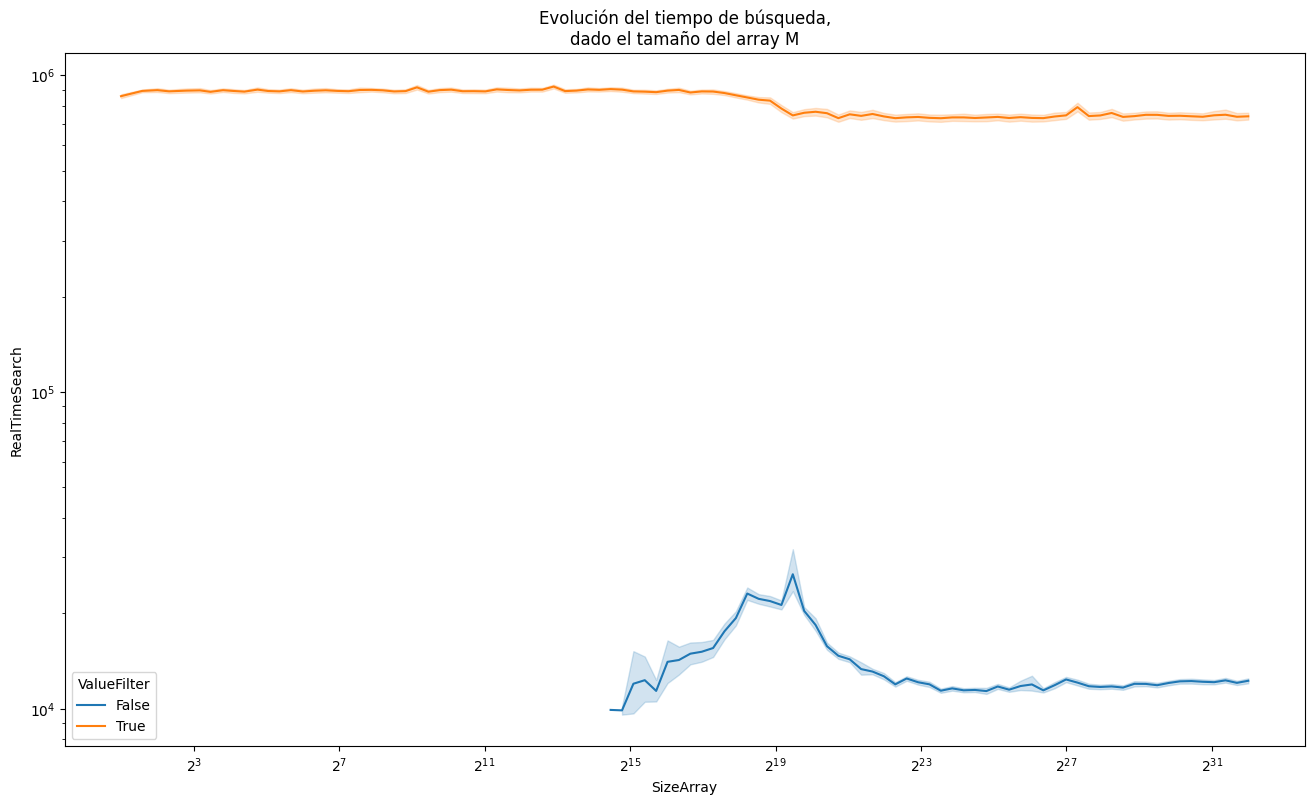

In [273]:
fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(dataset,
             y="RealTimeSearch",
             x="SizeArray",
             hue="ValueFilter",
             estimator="mean",
             ax = ax,
             )

ax.set_xscale("log", base = 2)
ax.set_yscale("log", base = 10)
ax.set_title("Evolución del tiempo de búsqueda,\ndado el tamaño del array M")
plt.show()

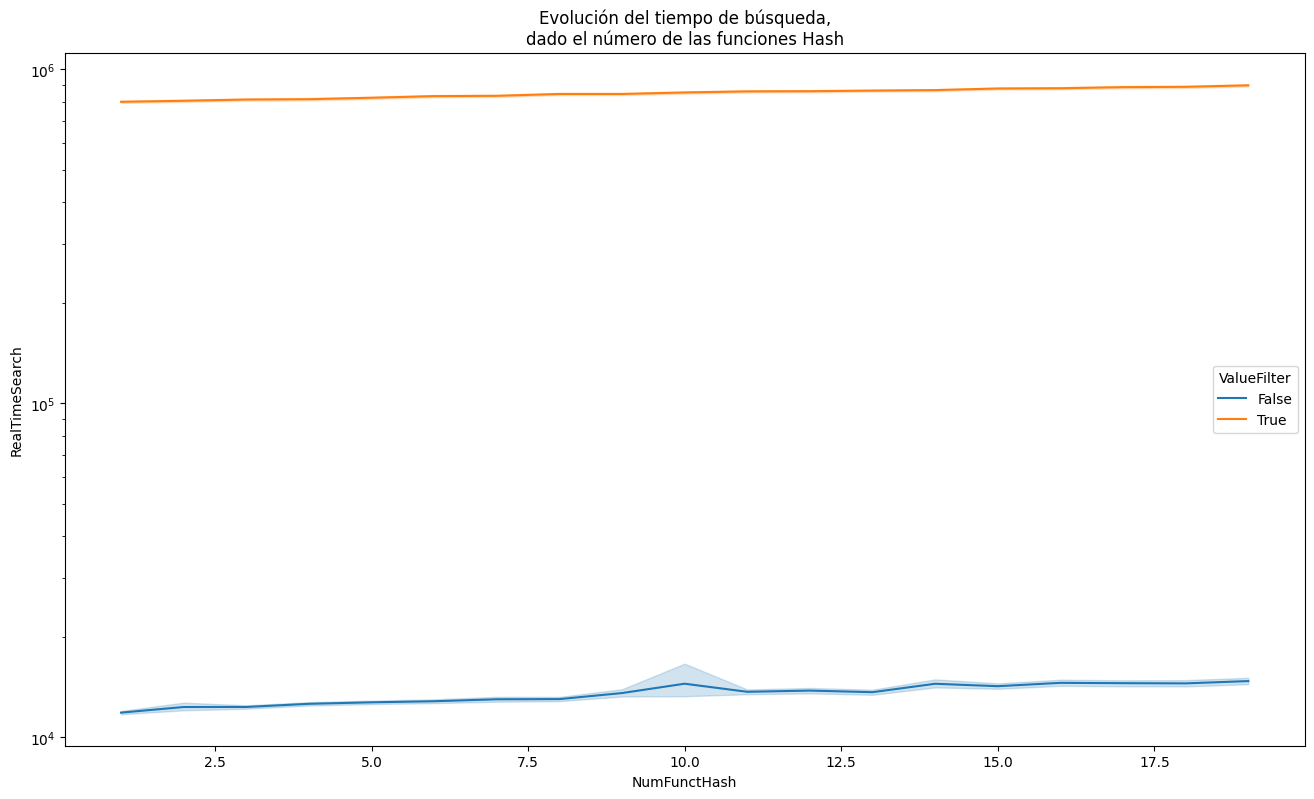

In [274]:
fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(dataset,
             y="RealTimeSearch",
             x="NumFunctHash",
             hue="ValueFilter",
             estimator="mean",
             ax=ax
             )
ax.set_yscale("log", base = 10)
ax.set_title("Evolución del tiempo de búsqueda,\ndado el número de las funciones Hash")
plt.show()

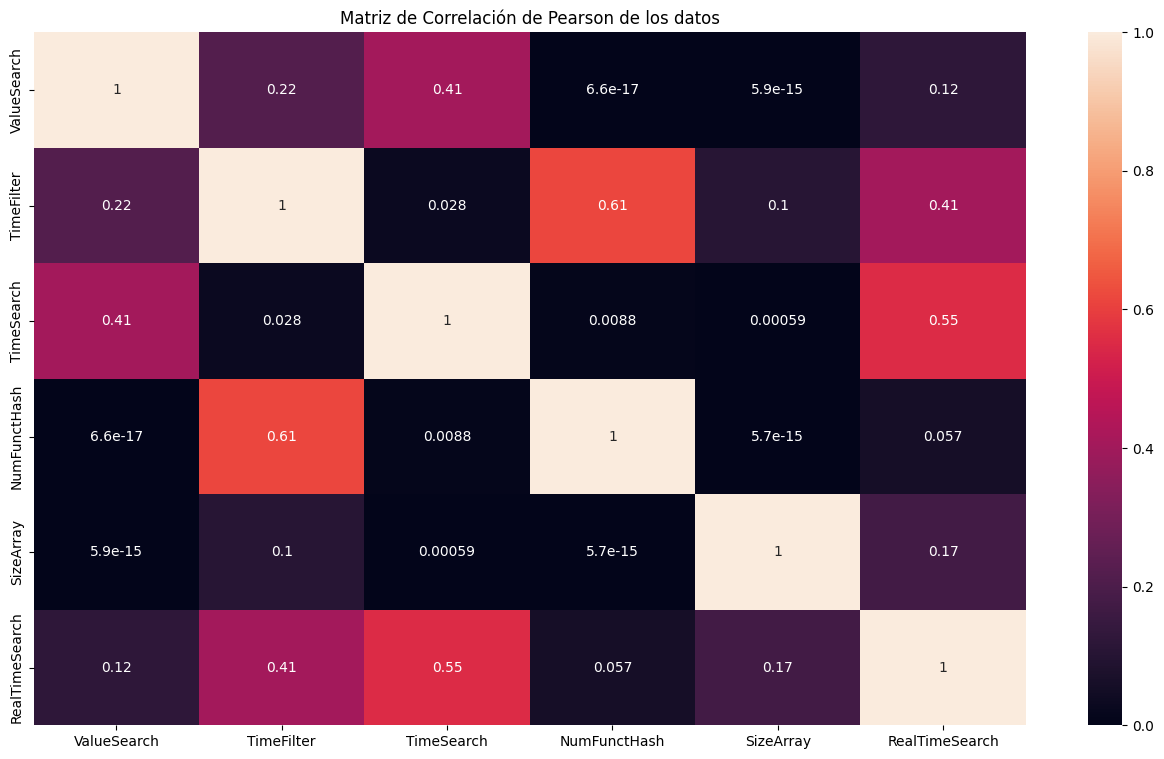

In [275]:
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(abs(dataset.drop(columns="ValueFilter").corr(numeric_only=True)),
            annot=True,
            ax=ax)
ax.set_title("Matriz de Correlación de Pearson de los datos")
plt.show()

In [276]:
df_filter_bloom_stats = pd.DataFrame()

df_filter_bloom_stats["NumFunctHash"] = dataset["NumFunctHash"].unique()
df_filter_bloom_stats = df_filter_bloom_stats.merge(pd.DataFrame({"SizeArray": dataset["SizeArray"].unique()}), how="cross")
true_positive = []
false_positive = []
true_negative = []
false_negative = []
for k, M in df_filter_bloom_stats.iloc:
    df_aux = dataset[(dataset["SizeArray"] == M) &
                     (dataset["NumFunctHash"] == k)][["ValueSearch","ValueFilter"]]
    true_positive += [len(df_aux[(df_aux["ValueSearch"] == True) & (df_aux["ValueFilter"] == True)])]
    false_positive += [len(df_aux[(df_aux["ValueSearch"] == False) & (df_aux["ValueFilter"] == True)])]
    true_negative += [len(df_aux[(df_aux["ValueSearch"] == False) & (df_aux["ValueFilter"] == False)])]
    false_negative += [len(df_aux[(df_aux["ValueSearch"] == True) & (df_aux["ValueFilter"] == False)])]

df_filter_bloom_stats["TruePositive"] = true_positive
df_filter_bloom_stats["FalsePositive"] = false_positive
df_filter_bloom_stats["TrueNegative"] = true_negative
df_filter_bloom_stats["FalseNegative"] = false_negative

df_filter_bloom_stats["RateFalsePositive"] = df_filter_bloom_stats["FalsePositive"]/(df_filter_bloom_stats["FalsePositive"]+df_filter_bloom_stats["TruePositive"])
df_filter_bloom_stats["RateFalseNegative"] = df_filter_bloom_stats["FalseNegative"]/(df_filter_bloom_stats["FalseNegative"] + df_filter_bloom_stats["TrueNegative"])

In [277]:
dataset[(dataset["ValueSearch"] == False)]

,WordSearch,ValueFilter,ValueSearch,TimeFilter,TimeSearch,NumFunctHash,SizeArray,RealTimeSearch
100,THE LAST SONG,True,False,4400,624400,1,2,628800
101,MYSTIC RIVER,True,False,11700,584100,1,2,595800
102,BILLY ELLIOT,True,False,5800,527600,1,2,533400
103,THE SHOW CONTAINED A LAUGH TRACK CREATED BY T...,True,False,6500,479100,1,2,485600
105,QUERELLE,True,False,2600,625600,1,2,628200
...,...,...,...,...,...,...,...,...
379995,THE ADVENTURES OF MILO AND OTIS,False,False,10500,931700,19,4294967296,10500
379996,CHILDREN OF THE DAMNED,False,False,9400,936200,19,4294967296,9400
379997,STALIN'S JAMES BOND,False,False,9800,928700,19,4294967296,9800
379998,BACK TO SCHOOL,False,False,9200,943500,19,4294967296,9200


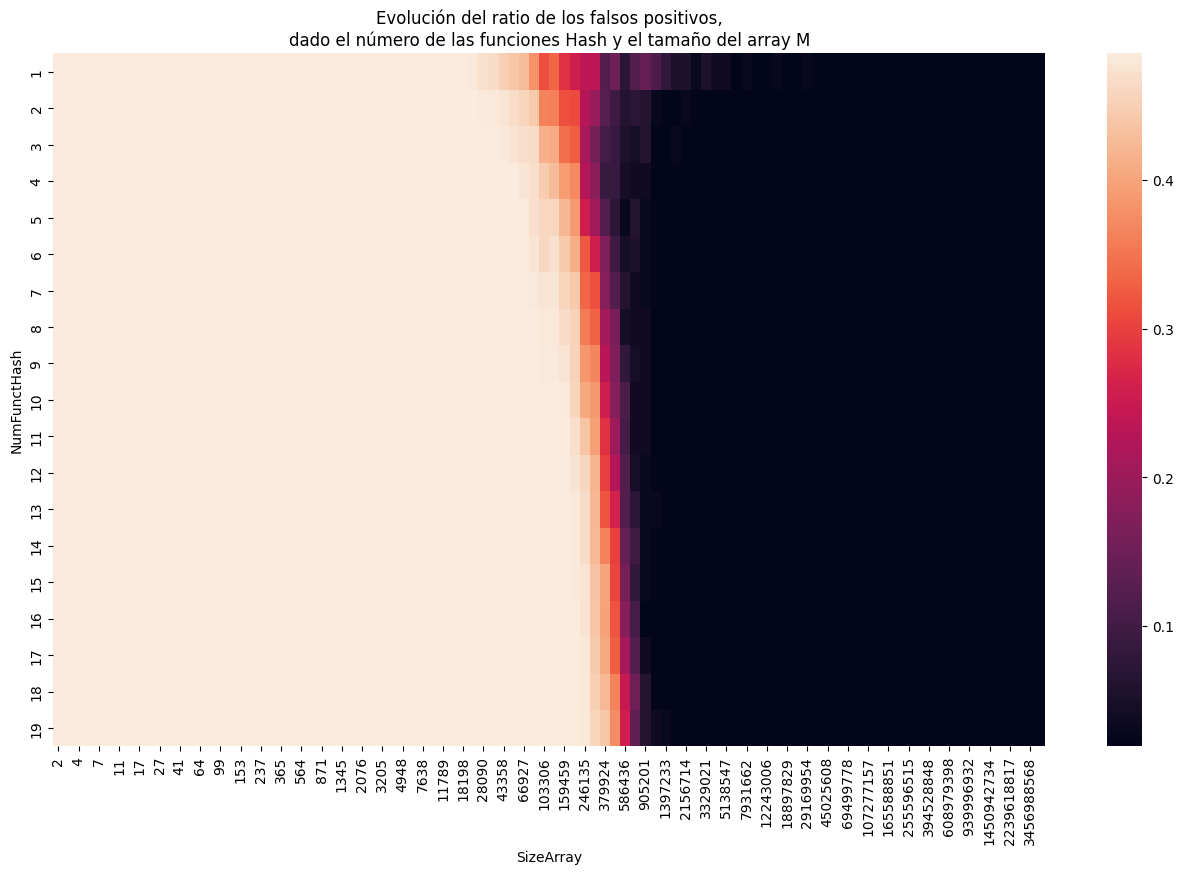

In [278]:
fig, ax = plt.subplots(figsize=(16,9))

sns.heatmap(df_filter_bloom_stats.pivot_table(values="RateFalsePositive", index="NumFunctHash", columns="SizeArray"),
            ax=ax)
ax.set_title("Evolución del ratio de los falsos positivos,\ndado el número de las funciones Hash y el tamaño del array M")
plt.show()

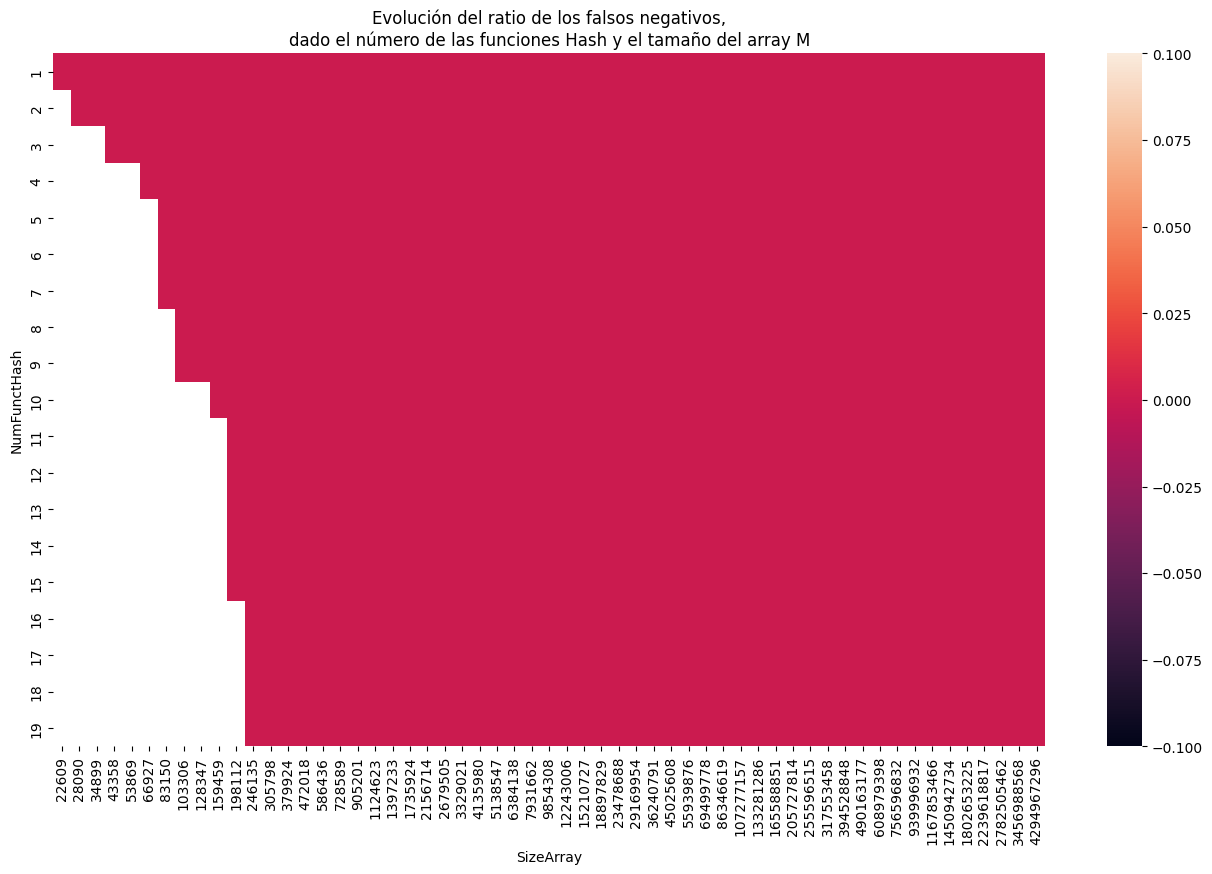

In [279]:
fig, ax = plt.subplots(figsize=(16,9))

sns.heatmap(df_filter_bloom_stats.pivot_table(values="RateFalseNegative", index="NumFunctHash", columns="SizeArray"),
            ax=ax)
ax.set_title("Evolución del ratio de los falsos negativos,\ndado el número de las funciones Hash y el tamaño del array M")
plt.show()

In [280]:
df_filter_bloom_stats

,NumFunctHash,SizeArray,TruePositive,FalsePositive,TrueNegative,FalseNegative,RateFalsePositive,RateFalseNegative
0,1,2,206,194,0,0,0.485000,NaN
1,1,3,206,194,0,0,0.485000,NaN
2,1,4,103,97,0,0,0.485000,NaN
3,1,5,103,97,0,0,0.485000,NaN
4,1,7,103,97,0,0,0.485000,NaN
...,...,...,...,...,...,...,...,...
1857,19,1802653225,103,2,95,0,0.019048,0.0
1858,19,2239618817,103,2,95,0,0.019048,0.0
1859,19,2782505462,103,2,95,0,0.019048,0.0
1860,19,3456988568,103,2,95,0,0.019048,0.0
